In [9]:
import matplotlib.pyplot as plt
import numpy as np

from src.data import load_characters, load_movies, load_awards
from src.utils.helpers import create_graph_from_data, get_communities
from src.utils.helpers import merge_movies_and_actors, filter_by_country, drop_nans, filter_by_language

movies = load_movies()
characters = load_characters()
actor_awards = load_awards()

characters['TotalAwards'] = actor_awards['awards'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
total_actors = len(characters)
awarded_actors = characters[characters['TotalAwards'] > 0]

probability_award = len(awarded_actors) / total_actors
print(f"Probability of an actor receiving an award: {probability_award:.2%}")

us_movies = filter_by_country(movies, country="United States of America")
us_movies = drop_nans(us_movies, column="Revenue")
us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)

G_US = create_graph_from_data(us_characters_movies)
communities = get_communities(G_US)

Probability of an actor receiving an award: 3.05%


KeyboardInterrupt: 

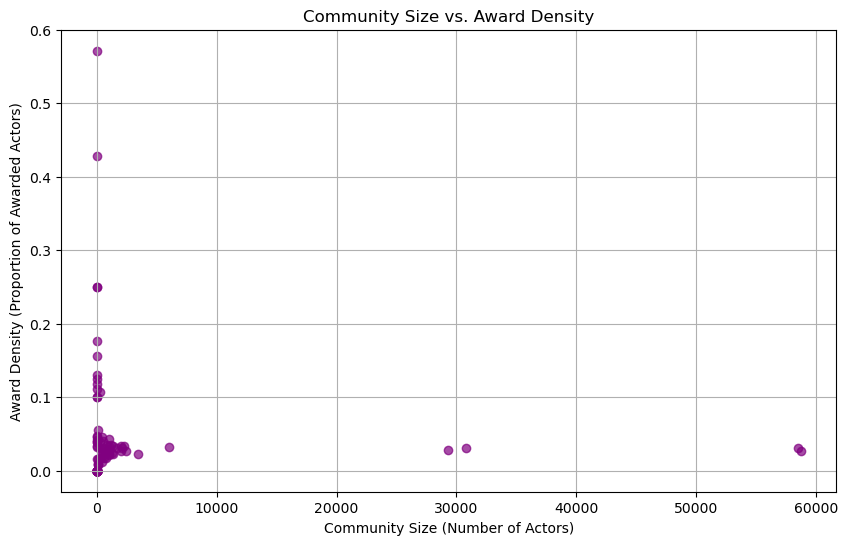

Clusters with high award density (>80%): 0
Clusters with low award density (<20%): 141
Average award density across communities: 2.79%


In [5]:
community_awards = {}
for community_id, community_members in enumerate(communities):
    community_actors = characters[characters['FreebaseActorId'].isin(community_members)]
    total_awards_in_community = community_actors['TotalAwards'].sum()
    awarded_actors_in_community = len(community_actors[community_actors['TotalAwards'] > 0])
    total_actors_in_community = len(community_actors)

    community_awards[community_id] = {
        "total_actors": total_actors_in_community,
        "awarded_actors": awarded_actors_in_community,
        "total_awards": total_awards_in_community,
        "award_density": awarded_actors_in_community / total_actors_in_community if total_actors_in_community > 0 else 0,
    }


community_sizes = [metrics['total_actors'] for metrics in community_awards.values()]
award_densities = [metrics['award_density'] for metrics in community_awards.values()]

plt.figure(figsize=(10, 6))
plt.scatter(community_sizes, award_densities, alpha=0.7, color="purple")
plt.title("Community Size vs. Award Density")
plt.xlabel("Community Size (Number of Actors)")
plt.ylabel("Award Density (Proportion of Awarded Actors)")
plt.grid(True)
plt.show()

high_award_density_clusters = [cid for cid, metrics in community_awards.items() if metrics['award_density'] > 0.8]
low_award_density_clusters = [cid for cid, metrics in community_awards.items() if metrics['award_density'] < 0.2]

print(f"Clusters with high award density (>80%): {len(high_award_density_clusters)}")
print(f"Clusters with low award density (<20%): {len(low_award_density_clusters)}")

average_award_density = np.mean(award_densities)
print(f"Average award density across communities: {average_award_density:.2%}")


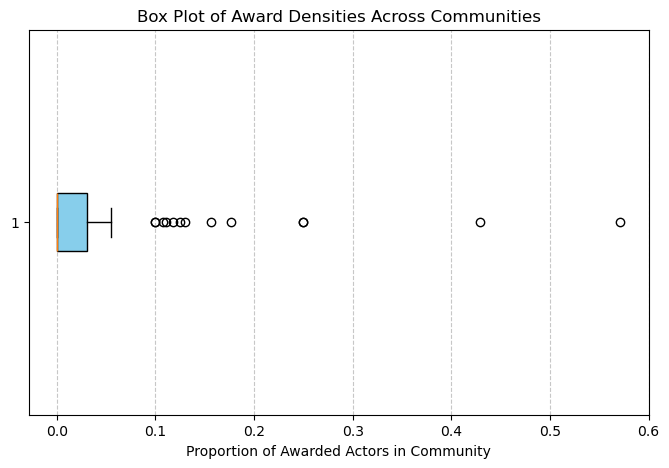

In [8]:
award_densities = [metrics['award_density'] for metrics in community_awards.values()]

plt.figure(figsize=(8, 5))
plt.boxplot(award_densities, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue", color="black"))
plt.title("Box Plot of Award Densities Across Communities")
plt.xlabel("Proportion of Awarded Actors in Community")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

The analysis shows a striking imbalance in the distribution of awarded actors across clusters. Not a single cluster had a high award density (more than 80% of its actors being award winners). On the other hand, the vast majority—141 clusters—had a very low award density, with less than 20% of their actors having received awards.

On average, only about 2.79% of actors in a given community were awarded, indicating that awards are rare and not concentrated within specific clusters. This suggests that awarded actors are widely dispersed among different communities rather than being grouped together. It challenges the idea that certain communities might exclusively consist of highly acclaimed actors. Instead, awards appear to be a less common individual achievement, irrespective of cluster dynamics.